In [1]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import pytket.qasm
from datetime import datetime
import numpy as np
import scipy
import matplotlib.pyplot as plt
from qibo import hamiltonians
from scipy.optimize import minimize
from qibo.symbols import X, Y, Z
from copy import deepcopy

In [109]:
def TLFIM_ref(nqubits, jx):
    tlfim_qibo = hamiltonians.SymbolicHamiltonian(
                sum([jx * X(i)*X(i+1) + Z(i) + X(i) for i in range(nqubits-1)]
                + [Z(nqubits-1)+ X(nqubits-1)]))
    return tlfim_qibo.matrix

# 1. XX interactions

Suppose that there is only $\sum XX$ and ignore the $Z$ and $X$ terms.


In [2]:
def XX_interaction(qc, q0, q1, t):
    qc.H(q0), qc.H(q1)
    qc.ZZPhase(t*2/np.pi, q0, q1)
    qc.H(q0), qc.H(q1)

In [ ]:
# check if re-ordering XX terms affect the result
t = np.pi/6
nqubits = 4
qc1 = Circuit(nqubits)
# one by one
XX_interaction(qc1, 0, 1, t)
XX_interaction(qc1, 1, 2, t)
XX_interaction(qc1, 2, 3, t)

# odd-even pair
qc2 = Circuit(nqubits)
XX_interaction(qc2, 0, 1, t)
XX_interaction(qc2, 2, 3, t)
XX_interaction(qc2, 1, 2, t)

# e^it/2(even)e^it(odd)e^it/2(even)
qc3 = Circuit(nqubits)
XX_interaction(qc3, 0, 1, t/2)
XX_interaction(qc3, 2, 3, t/2)
XX_interaction(qc3, 1, 2, t)
XX_interaction(qc3, 0, 1, t/2)
XX_interaction(qc3, 2, 3, t/2)
print(np.linalg.norm(qc1.get_unitary()-qc2.get_unitary()))
print(np.linalg.norm(qc1.get_unitary()-qc3.get_unitary()))

5.087681048627601e-16
2.3102244613642867e-15


Because $[Z_i,Z_{i+1}, Z_{_i+1}Z_{i+2}] = 0$ and $H\cdot H=I$, the TLFIM model is not affected by the $XX$ terms arrangement.

# 2. TLFIM

## 2.1 Test without Rz and Rx

In [73]:
def TLFIM_decomposition_XX(nqubits, t, jx=2, qc=None):
    # This function generates the circuit that simulates e^{itH}
    # where H is the TLFIM model
    # nqubits must be equal or greater than 2
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    for j in range(nqubits):
        # qc.Rz(t*2/np.pi, j)
        # qc.Rx(t*2/np.pi, j)
        qc.H(j)
    for q0, q1 in even_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for q0, q1 in odd_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for j in range(nqubits):
        qc.H(j)
    return qc

In [74]:
nqubits = 4
jx = 2
t_space = np.linspace(0, np.pi/6,15)

In [76]:
norms1 = []
norms2 = []
norms3 = []
for t in t_space:
    # note that when running this block, TLFIM_decomposition has rz and rx commented out
    tlfim_circ = TLFIM_decomposition_XX(nqubits, t, jx).get_unitary()
    tlfim_ref = scipy.linalg.expm(-1j*t*hamiltonians.SymbolicHamiltonian(sum([jx * X(i)*X(i+1) for i in range(nqubits-1)])).matrix)
    
    # using XX_interactions
    tlfim_xx_tket = Circuit(nqubits)
    for j in range(nqubits-1):
        XX_interaction(tlfim_xx_tket, j, j+1, jx*t)
    norms1.append(np.linalg.norm(tlfim_circ - tlfim_ref))
    norms2.append(np.linalg.norm(tlfim_circ - tlfim_xx_tket.get_unitary()))
    norms3.append(np.linalg.norm(tlfim_xx_tket.get_unitary() - tlfim_ref))

[Qibo 0.2.13|WARNING|2025-02-21 10:06:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:06:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:06:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:06:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:06:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:06:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:06:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:06:28]: Calculating 

Text(0.5, 1.0, 'Error in XX interactions')

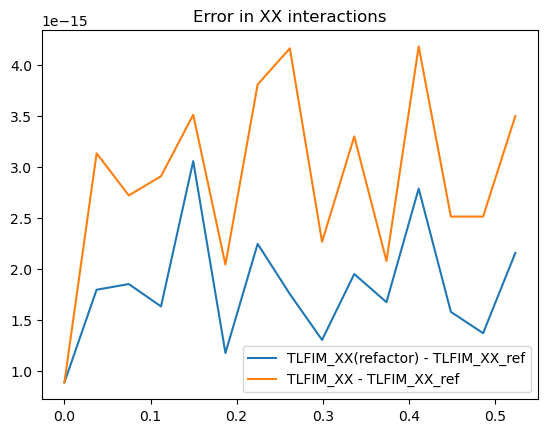

In [80]:
plt.plot(t_space, norms1, label='TLFIM_XX(refactor) - TLFIM_XX_ref')
# plt.plot(t_space, norms2, label='TLFIM_XX(refactor) - TLFIM_XX_ref')
plt.plot(t_space, norms3, label='TLFIM_XX - TLFIM_XX_ref')
plt.legend()
plt.title('Error in XX interactions')

From this graph, we see that the refactored XX interactions give less error because there are fewer Hadamard gates.

## 2.2 TLFIM with Rx

In [79]:
def TLFIM_decomposition_XX_X(nqubits, t, jx=2, qc=None):
    # This function generates the circuit that simulates e^{itH}
    # where H is the TLFIM model
    # nqubits must be equal or greater than 2
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    for j in range(nqubits):
        # qc.Rz(t*2/np.pi, j)
        qc.Rx(t*2/np.pi, j)
        qc.H(j)
    for q0, q1 in even_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for q0, q1 in odd_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for j in range(nqubits):
        qc.H(j)
    return qc

In [81]:
norms1 = []
norms2 = []
norms3 = []
for t in t_space:
    # note that when running this block, TLFIM_decomposition has rz and rx commented out
    tlfim_circ = TLFIM_decomposition_XX_X(nqubits, t, jx).get_unitary()
    tlfim_xx_x_ref = scipy.linalg.expm(-1j*t*hamiltonians.SymbolicHamiltonian(sum([jx * X(i)*X(i+1) + X(i) for i in range(nqubits-1)]+[X(nqubits-1)])).matrix)
    
    # using XX_interactions
    tlfim_xx_tket = Circuit(nqubits)
    for j in range(nqubits-1):
        XX_interaction(tlfim_xx_tket, j, j+1, jx*t)
        tlfim_xx_tket.Rx(t*2/np.pi, j)
    tlfim_xx_tket.Rx( t*2/np.pi, nqubits-1)
    norms1.append(np.linalg.norm(tlfim_circ - tlfim_xx_x_ref))
    norms2.append(np.linalg.norm(tlfim_circ - tlfim_xx_tket.get_unitary()))
    norms3.append(np.linalg.norm(tlfim_xx_tket.get_unitary() - tlfim_xx_x_ref))

[Qibo 0.2.13|WARNING|2025-02-21 10:10:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:10:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:10:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:10:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:10:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:10:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:10:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:10:09]: Calculating 

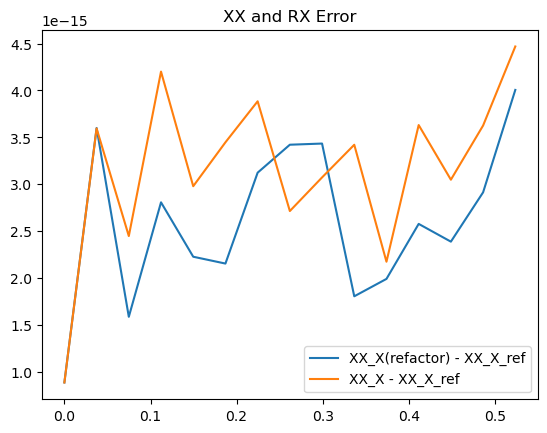

In [82]:
plt.plot(t_space, norms1, label='XX_X(refactor) - XX_X_ref')
plt.plot(t_space, norms3, label='XX_X - XX_X_ref')
plt.title('XX and RX Error')
plt.legend()

## 2.3 Symmetric second order

$$
e^{-it(\sum XX+\sum X + \sum Z)}\approx e^{-i\frac{t}{2}(\sum Z +\sum X)}e^{-it\sum XX} e^{-i\frac{t}{2}(\sum Z +\sum X)}
$$

In [86]:
def TLFIM_decomposition_1(nqubits, t, jx=2, qc=None):
    # This function generates the circuit that simulates e^{itH}
    # where H is the TLFIM model
    # nqubits must be equal or greater than 2
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    for j in range(nqubits):
        qc.Rz(t*2/np.pi, j)
        qc.Rx(t*2/np.pi, j)
        qc.H(j)
    for q0, q1 in even_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for q0, q1 in odd_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for j in range(nqubits):
        qc.H(j)
    return qc

In [87]:
def TLFIM_decomposition_2_RzRx(nqubits, t, jx=2, qc=None):
    # 2nd order with H1 = Rz + Rx, H2 = XX
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    for j in range(nqubits):
        qc.Rz(t/np.pi, j)
        qc.Rx(t/np.pi, j)
        qc.H(j)
    for q0, q1 in even_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for q0, q1 in odd_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for j in range(nqubits):
        qc.H(j)
        qc.Rz(t/np.pi, j)
        qc.Rx(t/np.pi, j)
    return qc

In [91]:
def TLFIM_decomposition_2_Rz(nqubits, t, jx=2, qc=None):
    # 2nd order with H1 = Rz, H2 = XX + X
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    for j in range(nqubits):
        qc.Rz(t/np.pi, j)
        qc.Rx(t*2/np.pi, j)
        qc.H(j)
    for q0, q1 in even_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for q0, q1 in odd_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for j in range(nqubits):
        qc.H(j)
        qc.Rz(t/np.pi, j)
    return qc

In [ ]:
def TLFIM_decomposition_2_XX(nqubits, t, jx=2, qc=None):
    # 2nd order with H1 = XX, H2 = Rz+Rx
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    for j in range(nqubits):
        qc.H(j)
    for q0, q1 in even_starting_pairs:
        qc.ZZPhase(jx*t/np.pi, q0, q1)
    for q0, q1 in odd_starting_pairs:
        qc.ZZPhase(jx*t/np.pi, q0, q1)
    for j in range(nqubits):
        qc.H(j)
        qc.Rz(t/np.pi, j)
        qc.Rx(t/np.pi, j)
        qc.H(j)
    for q0, q1 in even_starting_pairs:
        qc.ZZPhase(jx*t/np.pi, q0, q1)
    for q0, q1 in odd_starting_pairs:
        qc.ZZPhase(jx*t/np.pi, q0, q1)
    for j in range(nqubits):
        qc.H(j)
    return qc

In [92]:
norms1 = []
norms2 = []
norms3 = []
norms4 = []
for t in t_space:
    # note that when running this block, TLFIM_decomposition has rz and rx commented out
    tlfim_1 = TLFIM_decomposition_1(nqubits, t, jx).get_unitary()
    tlfim_2_Rz = TLFIM_decomposition_2_Rz(nqubits, t, jx).get_unitary()
    tlfim_2_RzRx = TLFIM_decomposition_2_RzRx(nqubits, t, jx).get_unitary()
    tlfim_2_XX = TLFIM_decomposition_2_XX(nqubits, t, jx).get_unitary()
    tlfim_ref = scipy.linalg.expm(-1j*t*hamiltonians.SymbolicHamiltonian(sum([jx * X(i)*X(i+1) + X(i) + Z(i) for i in range(nqubits-1)]+[X(nqubits-1)+Z(nqubits-1)])).matrix)
    norms1.append(np.linalg.norm(tlfim_1 - tlfim_ref))
    norms2.append(np.linalg.norm(tlfim_2_RzRx - tlfim_ref))
    norms3.append(np.linalg.norm(tlfim_2_Rz - tlfim_ref))
    norms4.append(np.linalg.norm(tlfim_2_XX - tlfim_ref))

[Qibo 0.2.13|WARNING|2025-02-21 10:18:24]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:18:24]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:18:24]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:18:24]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:18:24]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:18:24]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:18:24]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-02-21 10:18:24]: Calculating 

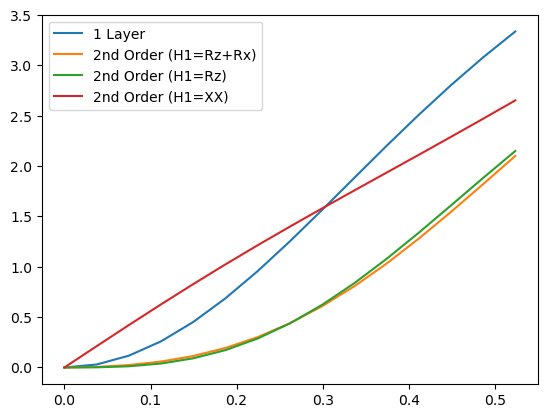

In [93]:
plt.plot(t_space, norms1, label='1 Layer')
plt.plot(t_space, norms2, label='2nd Order (H1=Rz+Rx)')
plt.plot(t_space, norms3, label='2nd Order (H1=Rz)')
plt.plot(t_space, norms4, label='2nd Order (H1=XX)')
plt.legend()

Therefore we will choose 2nd order formula with $H_1=Rx+Rz$

In [94]:
def TLFIM_decomposition(nqubits, t, jx=2, qc=None):
    # 2nd order with H1 = Rz + Rx, H2 = XX
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    for j in range(nqubits):
        qc.Rz(t/np.pi, j)
        qc.Rx(t/np.pi, j)
        qc.H(j)
    for q0, q1 in even_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for q0, q1 in odd_starting_pairs:
        qc.ZZPhase(jx*t*2/np.pi, q0, q1)
    for j in range(nqubits):
        qc.H(j)
        qc.Rz(t/np.pi, j)
        qc.Rx(t/np.pi, j)
    return qc

# 3. Trotterization

In [112]:
t_space = np.linspace(0, np.pi/10, 15)
norms = []
nqubits = 10
tlfim_ref = TLFIM_ref(nqubits, jx)
for t in t_space:
    tlfim_circ = TLFIM_decomposition(nqubits, t, jx)
    tlfim_evo_ref = scipy.linalg.expm(-1j*t*tlfim_ref)
    norms.append(np.linalg.norm(tlfim_circ.get_unitary() - tlfim_evo_ref))
    

[Qibo 0.2.13|WARNING|2025-02-21 10:26:34]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


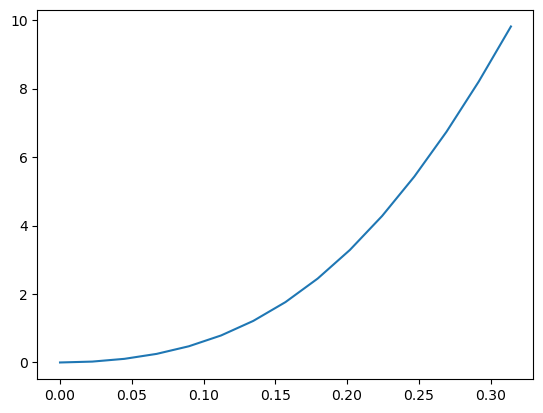

In [113]:
plt.plot(t_space, norms)

In [114]:
def trotter_circuit_TLFIM(nqubits, t, n_trotter):
    qc = Circuit(nqubits)
    dt = t/n_trotter
    for _ in range(n_trotter):
        qc = TLFIM_decomposition(nqubits, dt, qc=qc)
    return qc

In [116]:
t = np.pi/10
nqubits = 10
n_trotter = 10
tlfim_ref = TLFIM_ref(nqubits, jx)
U1 = scipy.linalg.expm(-1j*t*(tlfim_ref))

[Qibo 0.2.13|WARNING|2025-02-21 10:28:18]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [117]:
U2 = [trotter_circuit_TLFIM(nqubits, t, n).get_unitary() for n in range(1, n_trotter)]
diff_12 = [np.linalg.norm(U1-U2[i]) for i in range(n_trotter-1)]

Text(0.5, 1.0, 'Hamiltonian simulation error - trotter steps (L=10)')

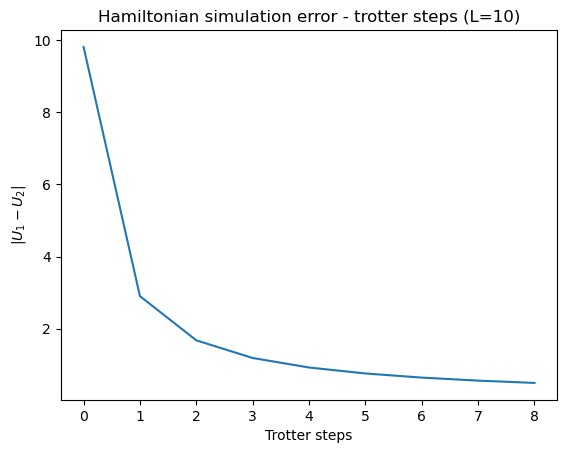

In [119]:
plt.plot(diff_12)
plt.xlabel('Trotter steps')
plt.ylabel(r'$|U_1-U_2|$')
plt.title(f'Hamiltonian simulation error - trotter steps (L={nqubits})')

# 4. Load VQE